## Домашнее задание №4

В качестве домашнего задания предлагаются следующие задачи:

1) Реализовать метод аугментации текстовых данных на основе дистрибутивных векторных представлений, который можно применить в перечисленных ниже задачах (на выбор) и проанализировать итоговое качество с/без аугментации.

2) Решить задачу регрессии с использованием текстовых признаков на англоязычном датасете [Medium Stories](https://www.kaggle.com/harrisonjansma/medium-stories).

3) Решить задачу детекции парафразов.

4) Использовать методы для нахождения оптимальных гиперпараметров модели.

5) Использовать кросс-валидацию и/или методы семплирования данных.

Это домашнее задание является "конструктором": вы можете выполнить интересующие вас блоки или получить больше 10 баллов.

Если качество моделей не повысилось, но попытка реализована верно, вы все равно получаете баллы (например, при конструировании собственных текстовых признаков). 

Дедлайн: **18 октября 23:59**


### Блок 1: Аугментация с заменой слов на основе ```word2vec``` (2 балла)

* Можно использовать библиотеку ```gensim``` и модели [rusvectores](https://rusvectores.org/ru/models/)



In [125]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!mkdir /root/.local/bin
!cp mystem /root/.local/bin/mystem

--2020-11-08 19:03:00--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.243, 5.45.205.242, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.243|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskstoredata03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2020-11-08 19:03:00--  http://cache-mskstoredata03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskstoredata03.cdn.yandex.net (cache-mskstoredata03.cdn.yandex.net)... 37.9.96.14, 2a02:6b8:0:3706::12
Connecting to cache-mskstoredata03.cdn.yandex.net (cache-mskstoredata03.cdn.yandex.net)|37.9.96.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.

In [126]:
!wget -c http://vectors.nlpl.eu/repository/20/180.zip
!unzip 180.zip

--2020-11-08 19:03:04--  http://vectors.nlpl.eu/repository/20/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452317 (462M) [application/zip]
Saving to: ‘180.zip’

180.zip             100%[===================>] 462.01M  21.9MB/s    in 27s     

2020-11-08 19:03:31 (17.2 MB/s) - ‘180.zip’ saved [484452317/484452317]

Archive:  180.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [127]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)
model.init_sims(replace=True)

In [128]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install natasha

In [161]:
from razdel import tokenize
import string
from pymystem3 import Mystem
import numpy as np


mystem = Mystem()
stopwords_ru = stopwords.words("russian")

def is_sw(x, stopwords=stopwords_ru):
  #if x in stopwords_ru:
    #return False
  if x in string.punctuation:
    return False
  else:
    return True


def get_tokens(text):
    tokenized_text = tokenize(text)
    return [t.text for t in tokenized_text if is_sw(t.text)]
    

def my_lemmatize(texts, mystem=mystem):
    texts = [texts]
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 1000)
    res = []
    for txtp in txtpart:
        alltexts = ' '.join([txt + ' brf ' for txt in txtp])
        words = mystem.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'brf':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res[0]


from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

def pos_tags(text, morph=morph):
    tokens = get_tokens(text)
    analyses = [morph.parse(word) for word in tokens]
    pos_tags = [a[0].tag.POS for a in analyses]
    return pos_tags

def lemmatize_and_pos_tag(text):
    lemmas = my_lemmatize(text)
    pos_tags_list = pos_tags(text)
    lemmas_pos = []
    for i in range(len(pos_tags_list)):
        try:
            if lemmas[i][0] not in string.punctuation:
                lemmas_pos.append(lemmas[i] + '_' + pos_tags_list[i])
        except:
            continue
    return lemmas_pos

Напишите функцию, которая заменяет слова во входном предложении их ближайшими семантическими ассоциатами (1 балл).

In [131]:
def augment_word2vec(sentence, model=model):
    lemmas = lemmatize_and_pos_tag(sentence)
    similar_lemmas_list = [model.most_similar(l, topn=1)[0][0].split('_')[0] for l in lemmas]
    return ' ' .join(similar_lemmas_list)

In [132]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sent = "мама помыла окно"

# пример работы наивной функции
augment_word2vec(sent)

'мама вымывать окошко'

In [133]:
a = morph.parse('маме')[0]
b = morph.parse('папа')[0]
tags = a.tag
dir(tags)
b.inflect(tags.grammemes) == None
#tags.grammemes

True

In [134]:
word = 'мама_NOUN'
my_sim = None
for w in model.most_similar(word, topn=100):
    if w[0].split('_')[1] == word.split('_')[1]:
        my_sim = w
        break
my_sim

('бабушка_NOUN', 0.7570064067840576)

Измените функцию так, чтобы заменялись слова, относящиеся к 
заданному набору пос-тегов (например, ADJ, NOUN), и сохранялась грамматика (1 балл). 

In [137]:
def same_pos_w(word, model=model):
    try:
        for w in model.most_similar(word, topn=100):
            if w[0].split('_')[1] == word.split('_')[1]:
                return w[0]
        return ' '
    except:
        return ' '


def save_grammar(sentence):
    tokens = get_tokens(sentence)
    grammemes_list = [morph.parse(w)[0].tag.grammemes for w in tokens]
    return grammemes_list, tokens
    

def augment_word2vec_pos(sentence, model=model):
    """если среди первых 100 совпадений не найдено слово с таким же pos или
       такими же грамматическими характеристиками, я его не заменяю. 
       для агументации данных этого должно быть достаточно"""

    lemmas = lemmatize_and_pos_tag(sentence)
    #similar_lemmas_list = [same_pos_w(l).split('_')[0] for l in lemmas]
    similar_lemmas_list = []
    grammemes_list, tokens = save_grammar(sentence)
    for i in range(len(lemmas)):
        l = lemmas[i]
        sim_pos_w = same_pos_w(l).split('_')[0]
        sim_pos_gram_w = morph.parse(sim_pos_w)[0].inflect(grammemes_list[i])
        if sim_pos_w==None or sim_pos_gram_w==None:
            similar_lemmas_list.append(tokens[i])
        else:
            similar_lemmas_list.append(sim_pos_gram_w[0])
    return ' '.join(similar_lemmas_list)


sent = "мамы помыла окна"
augment_word2vec_pos(sent)

'бабушки помыла окошка'

### Блок 2: Регрессия; Medium Stories (до 8 баллов)

Датасет можно скачать [здесь](https://yadi.sk/d/90JykTO48fL6qw) или со страницы кегли. Можно взять подвыборку.



Подзадачи:

1.   Эксплоративный анализ данных (1 балл)
2.   Отбор важных признаков, поиск гиперпараметров, минимизация переобучения (2 балла)
3.   Адаптация аугментации данных с заменой слов (1 балл)
4.   Конструирование текстовых признаков (2 балла)
5.   Сравнение качества моделей, выбор наилучшей (1 балл)
6.   Анализ ошибок (1 балл)  

In [62]:
!pip3 install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/90JykTO48fL6qw) -o medium_stories.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  157M  100  157M    0     0  14.1M      0  0:00:11  0:00:11 --:--:-- 20.3M


In [63]:
#%cd gdrive/My\ Drive/

!unzip medium_stories.zip

Archive:  medium_stories.zip
replace Medium_Clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace Medium_Clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Medium_Clean.csv        


In [ ]:
import pandas as pd

# можно не использовать колонки с тегами
usecols = ["Title", "Subtitle", "Image", "Author", "Publication", "Year", "Month", "Day", "Reading_Time", "Claps", "url", "Author_url"]

medium = pd.read_csv("Medium_Clean.csv", sep=",", usecols=usecols)
medium["Claps"] = medium["Claps"].astype(int)
medium.head()

## 1. Эксплоративный анализ данных 


In [284]:
"""вот здесь https://github.com/harrisonjansma/Analyzing_Medium/blob/master/Medium_EDA_expanded.ipynb 
есть хороший анализ этих данных, так что большую часть я просто оттуда взяла"""

print("Number of Articles: ", medium.shape[0])
print("Number of Authors: ", medium.Author.value_counts().shape[0])
print("Number of Publications: ", medium.Publication.value_counts().shape[0])
print('\n')
print("Minimum # CLaps by an Article: ", int(medium.Claps.min()), )
print("Maximum # Claps by an Article: ", int(medium.Claps.max()))
print("Median # Claps by an Article: ", int(medium.Claps.median()))
print("Mean # Claps by an Article: ", int(medium.Claps.mean()))

Number of Articles:  1391033
Number of Authors:  351584
Number of Publications:  43045


Minimum # CLaps by an Article:  0
Maximum # Claps by an Article:  291000
Median # Claps by an Article:  1
Mean # Claps by an Article:  109


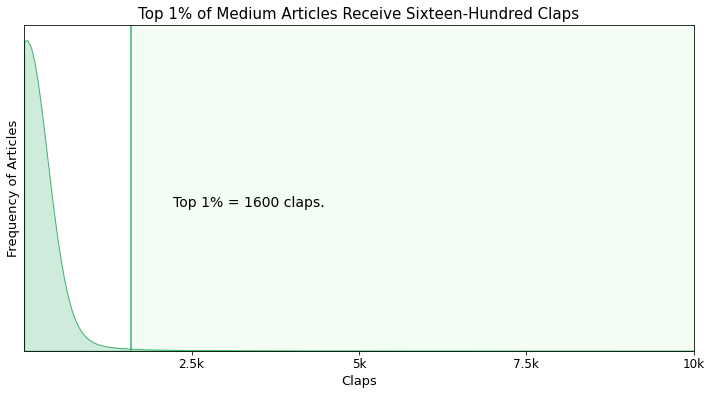

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_frequency(kde_data, clip=[0,10000],bw_adjust=0.1,yvariable = "Article", xvariable = "claps", title = "Exceptional",shorten=False, claplocs=[], kclaps=[]):
    plt.figure(figsize=(12,6))
    sns.kdeplot(kde_data, shade=True, bw=0.3, legend=False, clip=clip, color = "mediumseagreen" )
    ninenine = kde_data.quantile(q=0.99)
    plt.axvline(x=ninenine, color="mediumseagreen")
    plt.axvspan(ninenine, clip[1], alpha=0.1, color='lightgreen')
    plt.text(ninenine+(clip[1]-ninenine)*0.075,
                       plt.yticks()[0][-1]/2.5,
                       "Top 1% = "+str(int(ninenine))+ " "+xvariable+".",
                       fontsize=14)

    plt.title(title, fontsize=15)
    plt.ylabel("Frequency of "+yvariable.title(), fontsize=13)
    plt.yticks([])

    plt.xlabel(xvariable.title(), fontsize=13)
    if shorten:
        plt.xticks(claplocs,kclaps, fontsize=12)
    plt.xlim(1,clip[1])

kclaps = ["0","2.5k", "5k", "7.5k", "10k", "12.5k", "15k", "17.5k", "20k"]
claplocs = [0,2500, 5000,7500, 10000,12500,15000,17500,20000]
#KDE plot, shade below curve, clip arg includes values of 0 to 20000

plot_frequency(medium.Claps,
              clip=[0,10000],
               yvariable="Articles",
               xvariable="claps",
              title="Top 1% of Medium Articles Receive Sixteen-Hundred Claps",
               shorten=True,
              claplocs=claplocs,
              kclaps=kclaps)


plt.show()

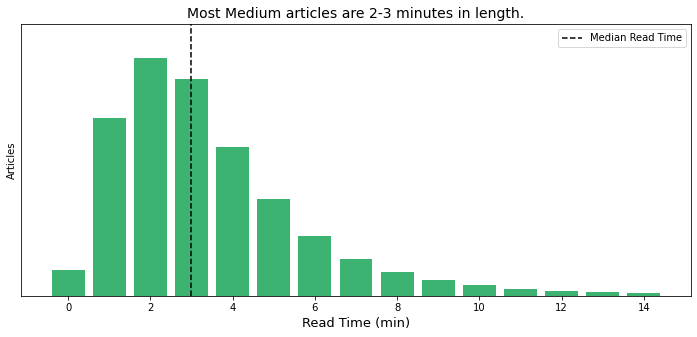

In [286]:
avs=[]
medians=[]
total_cs = []
readts=[]
entries = []
for x in range(15):
    medians.append(medium[medium.Reading_Time==x].Claps.quantile(q=0.5))
    readts.append(x)
    entries.append(medium[medium.Reading_Time==x].shape[0])
    total_cs.append(medium[medium.Reading_Time==x].Claps.sum())

plt.figure(figsize=(12,5))
plt.bar(readts,entries, color="mediumseagreen")
plt.vlines(medium.Reading_Time.median(),0,350000,
           color="black",
           linestyle="dashed",
           label="Median Read Time")
plt.title("Most Medium articles are 2-3 minutes in length.", fontsize=14)
#plt.yticks([0,100000,200000,300000], ["0","100k", "200k", "300k"])
plt.yticks([])
plt.ylim(0,350000)
plt.ylabel("Articles")
plt.xlabel("Read Time (min)", fontsize=13)
plt.legend()

plt.show()

In [287]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle

# Конструирование текстовых признаков


In [288]:
medium = medium.sample(1000)

In [289]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(medium, test_size=0.2)

In [290]:
punctuation = ',!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

medium['Clean_subtitle'] = medium['Subtitle'].apply(lambda x: re.sub(r'http\S+', '', x) if not pd.isnull(x) else '')
medium['Clean_subtitle'] = medium['Subtitle'].apply(lambda x: re.sub(r'http\S+', '', x) if not pd.isnull(x) else '')

medium['Clean_subtitle'] = medium['Clean_subtitle'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
medium['Clean_subtitle'] = medium['Clean_subtitle'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
medium['Clean_subtitle'] = medium['Clean_subtitle'].str.lower()
medium['Clean_subtitle'] = medium['Clean_subtitle'].str.lower()

# remove numbers
medium['Clean_subtitle'] = medium['Clean_subtitle'].str.replace("[0-9]", " ")
medium['Clean_subtitle'] = medium['Clean_subtitle'].str.replace("[0-9]", " ")

# remove whitespaces
medium['Clean_subtitle'] = medium['Clean_subtitle'].apply(lambda x:' '.join(x.split()))
medium['Clean_subtitle'] = medium['Clean_subtitle'].apply(lambda x: ' '.join(x.split()))

In [291]:
medium['Clean_title'] = medium['Title'].apply(lambda x: re.sub(r'http\S+', '', x) if not pd.isnull(x) else '')
medium['Clean_title'] = medium['Title'].apply(lambda x: re.sub(r'http\S+', '', x) if not pd.isnull(x) else '')

medium['Clean_title'] = medium['Clean_title'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
medium['Clean_title'] = medium['Clean_title'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
medium['Clean_title'] = medium['Clean_title'].str.lower()
medium['Clean_title'] = medium['Clean_title'].str.lower()

# remove numbers
medium['Clean_title'] = medium['Clean_title'].str.replace("[0-9]", " ")
medium['Clean_title'] = medium['Clean_title'].str.replace("[0-9]", " ")

# remove whitespaces
medium['Clean_title'] = medium['Clean_title'].apply(lambda x:' '.join(x.split()))
medium['Clean_title'] = medium['Clean_title'].apply(lambda x: ' '.join(x.split()))

In [292]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    j = 0
    l = len(texts)
    for i in texts:
        if j%1000 == 0:
            print(j*100/l)
        j += 1
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [ ]:
!pip install "tensorflow>=1.7.0"
!pip install tensorflow-hub

In [ ]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [171]:
import tensorflow_hub as hub
import tensorflow as tf


def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
medium['Lemmas_title'] = lemmatization(medium['Clean_title'])

In [ ]:
medium['Lemmas_subtitle'] = lemmatization(medium['Clean_subtitle'])

In [ ]:
list_medium = [medium[i:i+100] for i in range(0,medium.shape[0],100)]
elmo_subt = [elmo_vectors(x['Clean_subtitle']) for x in list_medium]
elmo_title = [elmo_vectors(x['Clean_title']) for x in list_medium]

In [299]:
elmo_subt_new = np.concatenate(elmo_subt, axis = 0)
elmo_title_new = np.concatenate(elmo_title, axis = 0)

In [300]:
medium['elmo_subt'] = medium['Title']
medium['elmo_title'] = medium['Title']

medium['elmo_subt'] = list(elmo_subt_new)
medium['elmo_title'] = list(elmo_title_new)

In [302]:
medium.reset_index(inplace=True)

In [ ]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin
# Try Word2Vec with Gensim
import gensim
# Load pretrained vectors from Google
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

In [ ]:
medium['w2vec_title'] = np.zeros(len(medium['Title']))
medium['w2vec_subtitle'] = np.zeros(len(medium['Title']))
lemmas_vectors_title = np.zeros((len(medium['Lemmas_title']), model.vector_size))
lemmas_vectors_subtitle = np.zeros((len(medium['Lemmas_title']), model.vector_size))
vec_title = np.zeros((model.vector_size,))
vec_subtitle = np.zeros((model.vector_size,))
w2vec_title = []
w2vec_subtitle = []

for i, title in enumerate(medium['Lemmas_title']):
    for idx, lemma in enumerate(title.split(' ')):
        if lemma in model:
            lemmas_vectors_title[idx] = model[lemma]
    if lemmas_vectors_title.shape[0] is not 0:
        vec_title = np.mean(lemmas_vectors_title, axis=0)
        w2vec_title.append(vec_title)
medium['w2vec_title'] = w2vec_title

for i, subtitle in enumerate(medium['Lemmas_subtitle']):
    for idx, lemma in enumerate(subtitle.split(' ')):
        if lemma in model:
            lemmas_vectors_subtitle[idx] = model[lemma]
    if lemmas_vectors_subtitle.shape[0] is not 0:
        vec_subtitle = np.mean(lemmas_vectors_subtitle, axis=0)
        w2vec_subtitle.append(vec_title)
medium['w2vec_subtitle'] = w2vec_subtitle


medium.head()

In [306]:
#medium = DataFrame.from_csv('medium100.csv')

# Адаптация аугментации данных с заменой слов 

In [307]:
def augment_word2vec_en(sentence, model=model):
    lemmas = sentence.split(' ')
    similar_lemmas_list = []
    for l in lemmas:
        try:
            ms = model.most_similar(l, topn=1)[0][0]
        except KeyError:
            ms = l
        similar_lemmas_list.append(ms)
    return ' ' .join(similar_lemmas_list)

augment_word2vec_en('Online animation tool provide game to designer', model=model)

'online 3D_animation tools providing games to Designer'

In [308]:
medium['title_aug'] = [augment_word2vec_en(title) for title in medium['Clean_title']]

In [309]:
medium['subtitle_aug'] = [augment_word2vec_en(title) for title in medium['Clean_subtitle']]

In [310]:
medium['w2vec_title_aug'] = np.zeros(len(medium['Title']))
medium['w2vec_subtitle_aug'] = np.zeros(len(medium['Title']))
lemmas_vectors_title = np.zeros((len(medium['Lemmas_title']), model.vector_size))
lemmas_vectors_subtitle = np.zeros((len(medium['Lemmas_title']), model.vector_size))
vec_title = np.zeros((model.vector_size,))
vec_subtitle = np.zeros((model.vector_size,))
w2vec_title = []
w2vec_subtitle = []

for i, title in enumerate(medium['title_aug']):
    for idx, lemma in enumerate(title.split(' ')):
        if lemma in model:
            lemmas_vectors_title[idx] = model[lemma]
    if lemmas_vectors_title.shape[0] is not 0:
        vec_title = np.mean(lemmas_vectors_title, axis=0)
        w2vec_title.append(vec_title)
medium['w2vec_title_aug'] = w2vec_title

for i, subtitle in enumerate(medium['subtitle_aug']):
    for idx, lemma in enumerate(subtitle.split(' ')):
        if lemma in model:
            lemmas_vectors_subtitle[idx] = model[lemma]
    if lemmas_vectors_subtitle.shape[0] is not 0:
        vec_subtitle = np.mean(lemmas_vectors_subtitle, axis=0)
        w2vec_subtitle.append(vec_title)
medium['w2vec_subtitle_aug'] = w2vec_subtitle


medium.head()

,index,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url,Clean_subtitle,Clean_title,Lemmas_title,Lemmas_subtitle,elmo_subt,elmo_title,w2vec_title,w2vec_subtitle,title_aug,subtitle_aug,w2vec_title_aug,w2vec_subtitle_aug
0,1313109,The Magic of Techstars,Maslos journey through the LA accelerator.,1,Ross Ingram,Your Virtual Self,2018,2,5,5,112,https://medium.com/maslo/the-magic-of-techstar...,https://medium.com/@rossingram,maslos journey through the la accelerator.,the magic of techstars,the magic of techstar,maslos journey through the la accelerator .,"[-0.04853706, -0.023921939, 0.03507502, -0.009...","[-0.061915077, -0.02682703, 0.1259984, 0.04157...","[0.000595703125, 0.00026708984375, 2.34375e-05...","[0.00099859619140625, -0.001431396484375, 0.00...",this magical of techstars,maslos journeys thru this à_la accelerator.,"[0.000455078125, 0.0001597900390625, -4.980468...","[0.001406585693359375, -0.00058648681640625, 0..."
1,66684,"LBTC Airdrop/Trading Competition(May 18, 2018 ...",1) Retweet and follow @SwftCoin.2) Join Telegr...,0,SWFT Blockchain,NaN,2018,5,18,1,1,https://medium.com/@SwftCoin/lbtc-airdrop-trad...,https://medium.com/@SwftCoin,retweet and follow swftcoin. join telegram t.m...,lbtc airdroptrading competitionmay may,lbtc airdroptrade competitionmay may,retweet and follow swftcoin . join telegram t....,"[0.097530626, -0.026002742, 0.04355757, -0.004...","[0.019684669, 0.008933432, 0.15614727, -0.0294...","[0.000655517578125, 0.0002908935546875, 9.0820...","[0.00099859619140625, -0.001431396484375, 0.00...",lbtc airdroptrading competitionmay might,retweeting and Follow swftcoin. joining telegr...,"[0.0006826171875, 0.0002799072265625, 1.855468...","[0.001406585693359375, -0.00058648681640625, 0..."
2,1275432,"Standards, progress and Sisyphus","The story of Sisyphus, the cunning yet deplora...",1,Robbie Heygate,Birdie,2018,6,3,5,13,https://medium.com/birdiecare/standards-progre...,https://medium.com/@r.heygate.dev,the story of sisyphus the cunning yet deplorab...,standards progress and sisyphus,standard progress and sisyphus,the story of sisyphus the cunning yet deplorab...,"[-0.028576218, -0.10448623, 0.06018492, -0.047...","[-0.099755056, 0.01083775, 0.07674182, -0.0063...","[-0.000168212890625, 0.0002869873046875, 0.000...","[0.00099859619140625, -0.001431396484375, 0.00...",standard progess and sisyphus,this stories of sisyphus this devious not appa...,"[0.00030615234375, 0.00055029296875, 0.0001577...","[0.001406585693359375, -0.00058648681640625, 0..."
3,868932,Banyumala; The Hidden Paradise of Bali,Banyumala; The Hidden Paradise of Bali,1,New Bali,NaN,2018,3,16,3,0,https://medium.com/@newbalilistings/banyumala-...,https://medium.com/@newbalilistings,banyumala the hidden paradise of bali,banyumala the hidden paradise of bali,banyumala the hide paradise of bali,banyumala the hide paradise of bali,"[-0.047672395, 0.004356642, 0.07308206, -0.054...","[-0.12769243, 0.20327926, 0.20509268, -0.18665...","[0.0002685546875, 0.0002606201171875, -9.76562...","[0.00099859619140625, -0.001431396484375, 0.00...",banyumala this concealed tropical_paradise of ...,banyumala this concealed tropical_paradise of ...,"[0.0002392578125, 8.5418701171875e-05, 0.00022...","[0.001406585693359375, -0.00058648681640625, 0..."
4,724138,"Decisions, Decisions, Decisions.",Why do some find it so hard to make a decision?,1,Darlene Durling,NaN,2018,7,13,1,2,https://medium.com/@darlenedurling/decisions-d...,https://medium.com/@darlenedurling,why do some find it so hard to make a decision,decisions decisions decisions.,decision decision decision .,why do some find -PRON- so hard to make a deci...,"[-0.024256662, -0.00030070764, -0.028854074, -...","[-0.11300109, 0.1128686, 0.105815835, -0.02933...","[-3.9794921875e-05, 0.0002825927734375, 1.3000...","[0.00099859619140625, -0.001431396484375, 0.00...",decision decision decisions.,created_Benzinga_Pro want many discover that t...,"[0.0001376953125, 4.000854

In [ ]:
list_medium = [medium[i:i+100] for i in range(0,medium.shape[0],100)]
elmo_subt_aug = [elmo_vectors(x['subtitle_aug']) for x in list_medium]
elmo_title_aug = [elmo_vectors(x['title_aug']) for x in list_medium]

elmo_subt_new_aug = np.concatenate(elmo_subt_aug, axis = 0)
elmo_title_new_aug = np.concatenate(elmo_title_aug, axis = 0)

medium['elmo_subt_aug'] = list(elmo_subt_new_aug)
medium['elmo_title_aug'] = list(elmo_title_new_aug)

In [312]:
medium['elmo_subt_aug'] = medium['elmo_subt_aug'].apply(list)
medium['elmo_title_aug'] = medium['elmo_title_aug'].apply(list)
medium['elmo_subt'] = medium['elmo_subt'].apply(list)
medium['elmo_title'] = medium['elmo_title'].apply(list)
medium['w2vec_title'] = medium['w2vec_title'].apply(list)
medium['w2vec_subtitle'] = medium['w2vec_subtitle'].apply(list)
medium['w2vec_title_aug'] = medium['w2vec_title_aug'].apply(list)
medium['w2vec_subtitle_aug'] = medium['w2vec_subtitle_aug'].apply(list)

In [ ]:
#сохраняю получившийся датасет, чтобы не обрабатывать по новой каждый раз данные
import csv
medium.to_csv('medium1000_aug.tsv', sep='\t')
              #quoting=csv.QUOTE_ALL)

In [13]:
import pandas as pd
import numpy as np

In [14]:
medium = pd.read_csv('medium1000_aug.tsv', sep='\t')
medium.head(2)

,Unnamed: 0,index,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url,Clean_subtitle,Clean_title,Lemmas_title,Lemmas_subtitle,elmo_subt,elmo_title,w2vec_title,w2vec_subtitle,title_aug,subtitle_aug,w2vec_title_aug,w2vec_subtitle_aug,elmo_subt_aug,elmo_title_aug
0,0,1313109,The Magic of Techstars,Maslos journey through the LA accelerator.,1,Ross Ingram,Your Virtual Self,2018,2,5,5,112,https://medium.com/maslo/the-magic-of-techstar...,https://medium.com/@rossingram,maslos journey through the la accelerator.,the magic of techstars,the magic of techstar,maslos journey through the la accelerator .,"[-0.04853706, -0.023921939, 0.03507502, -0.009...","[-0.061915077, -0.02682703, 0.1259984, 0.04157...","[0.000595703125, 0.00026708984375, 2.34375e-05...","[0.00099859619140625, -0.001431396484375, 0.00...",this magical of techstars,maslos journeys thru this à_la accelerator.,"[0.000455078125, 0.0001597900390625, -4.980468...","[0.001406585693359375, -0.00058648681640625, 0...","[-0.052981656, -0.013130262, 0.05838853, -0.02...","[-0.037630267, -0.065115124, 0.16386811, 0.055..."
1,1,66684,"LBTC Airdrop/Trading Competition(May 18, 2018 ...",1) Retweet and follow @SwftCoin.2) Join Telegr...,0,SWFT Blockchain,NaN,2018,5,18,1,1,https://medium.com/@SwftCoin/lbtc-airdrop-trad...,https://medium.com/@SwftCoin,retweet and follow swftcoin. join telegram t.m...,lbtc airdroptrading competitionmay may,lbtc airdroptrade competitionmay may,retweet and follow swftcoin . join telegram t....,"[0.097530626, -0.026002742, 0.04355757, -0.004...","[0.019684669, 0.008933432, 0.15614727, -0.0294...","[0.000655517578125, 0.0002908935546875, 9.0820...","[0.00099859619140625, -0.001431396484375, 0.00...",lbtc airdroptrading competitionmay might,retweeting and Follow swftcoin. joining telegr...,"[0.0006826171875, 0.0002799072265625, 1.855468...","[0.001406585693359375, -0.00058648681640625, 0...","[0.029712413, 0.018943787, 0.07163218, -0.0082...","[0.017589757, -0.0126325255, 0.1587871, -0.011..."


# Сравнение качества моделей, выбор наилучшей
# Анализ ошибок 
# Отбор важных признаков, поиск гиперпараметров, минимизация переобучения 

In [16]:
#предобработка датасетов – нормализация численных данных 
#превращение категориальных аднных в one-hot вектора

from sklearn.preprocessing import scale

elmo_medium_data = medium[['Author', 'Image', 'Year', 'Month', 'Day', 
                     'Reading_Time', 'Claps', 'elmo_subt', 'elmo_title',
                      'elmo_subt_aug', 'elmo_title_aug']]

#elmo_medium_data['Reading_Time'] = scale(elmo_medium_data['Reading_Time'])
elmo_medium_data['Reading_Time'] = [i/elmo_medium_data['Reading_Time'].max() for i in elmo_medium_data['Reading_Time']]

one_hot = pd.get_dummies(elmo_medium_data['Year'], prefix='year')
elmo_medium_data = elmo_medium_data.drop('Year',axis = 1)
elmo_medium_data = elmo_medium_data.join(one_hot)

one_hot = pd.get_dummies(elmo_medium_data['Month'], prefix='month')
elmo_medium_data = elmo_medium_data.drop('Month',axis = 1)
elmo_medium_data = elmo_medium_data.join(one_hot)

one_hot = pd.get_dummies(elmo_medium_data['Day'], prefix='day')
elmo_medium_data = elmo_medium_data.drop('Day',axis = 1)
elmo_medium_data = elmo_medium_data.join(one_hot)

one_hot = pd.get_dummies(elmo_medium_data['Image'], prefix='image')
elmo_medium_data = elmo_medium_data.drop('Image',axis = 1)
elmo_medium_data = elmo_medium_data.join(one_hot)

one_hot = pd.get_dummies(elmo_medium_data['Author'], prefix='author')
elmo_medium_data = elmo_medium_data.drop('Author',axis = 1)
elmo_medium_data = elmo_medium_data.join(one_hot)

w2vec_medium_data = medium[['Author', 'Image', 'Year', 'Month', 'Day', 
                     'Reading_Time', 'Claps', 
                     'w2vec_title',	'w2vec_subtitle', 'w2vec_title_aug', 
                     'w2vec_subtitle_aug']]

w2vec_medium_data['Reading_Time'] = [i/w2vec_medium_data['Reading_Time'].max() for i in w2vec_medium_data['Reading_Time']]

one_hot = pd.get_dummies(w2vec_medium_data['Year'], prefix='year')
w2vec_medium_data = w2vec_medium_data.drop('Year',axis = 1)
w2vec_medium_data = w2vec_medium_data.join(one_hot)

one_hot = pd.get_dummies(w2vec_medium_data['Month'], prefix='month')
w2vec_medium_data = w2vec_medium_data.drop('Month',axis = 1)
w2vec_medium_data = w2vec_medium_data.join(one_hot)

one_hot = pd.get_dummies(w2vec_medium_data['Day'], prefix='day')
w2vec_medium_data = w2vec_medium_data.drop('Day',axis = 1)
w2vec_medium_data = w2vec_medium_data.join(one_hot)

one_hot = pd.get_dummies(w2vec_medium_data['Image'], prefix='image')
w2vec_medium_data = w2vec_medium_data.drop('Image',axis = 1)
w2vec_medium_data = w2vec_medium_data.join(one_hot)

one_hot = pd.get_dummies(w2vec_medium_data['Author'], prefix='author')
w2vec_medium_data = w2vec_medium_data.drop('Author',axis = 1)
w2vec_medium_data = w2vec_medium_data.join(one_hot)


#w2vec_medium_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
len(medium)

1000

In [ ]:
#после загрузки датасета из csv превращаем вектора из строк обратно в объекты
from ast import literal_eval


w2vec_medium_data['w2vec_subtitle'] = w2vec_medium_data['w2vec_subtitle'].apply(literal_eval)
w2vec_medium_data['w2vec_title'] = w2vec_medium_data['w2vec_title'].apply(literal_eval)
w2vec_medium_data['w2vec_subtitle_aug'] = w2vec_medium_data['w2vec_subtitle_aug'].apply(literal_eval)
w2vec_medium_data['w2vec_title_aug'] = w2vec_medium_data['w2vec_title_aug'].apply(literal_eval)

elmo_medium_data['elmo_subt'] = elmo_medium_data['elmo_subt'].apply(literal_eval)
elmo_medium_data['elmo_title'] = elmo_medium_data['elmo_title'].apply(literal_eval)
elmo_medium_data['elmo_subt_aug'] = elmo_medium_data['elmo_subt_aug'].apply(literal_eval)
elmo_medium_data['elmo_title_aug'] = elmo_medium_data['elmo_title_aug'].apply(literal_eval)

type(w2vec_medium_data['w2vec_subtitle'][0])

In [19]:
from sklearn.model_selection import train_test_split

elmo_train, elmo_test = train_test_split(elmo_medium_data, test_size=0.2)
w2vec_train, w2vec_test = train_test_split(w2vec_medium_data, test_size=0.2)

In [21]:
#конкатинируем аугментированные данные с train, удаляем их из test
elmo_test = elmo_test.drop(['elmo_subt_aug', 'elmo_title_aug'], axis=1)
w2vec_test = w2vec_test.drop(['w2vec_subtitle_aug', 'w2vec_title_aug'], axis=1)

elmo_train_aug = elmo_train.drop(['elmo_subt', 'elmo_title'], axis=1)
w2vec_train_aug = w2vec_train.drop(['w2vec_subtitle', 'w2vec_title'], axis=1)

elmo_train = elmo_train.drop(['elmo_subt_aug', 'elmo_title_aug'], axis=1)
w2vec_train = w2vec_train.drop(['w2vec_subtitle_aug', 'w2vec_title_aug'], axis=1)

elmo_train_aug = elmo_train_aug.rename(columns={'elmo_subt_aug': 'elmo_subt', 'elmo_title_aug': 'elmo_title'})
w2vec_train_aug = w2vec_train_aug.rename(columns={'w2vec_subtitle_aug': 'w2vec_subtitle', 'w2vec_title_aug': 'w2vec_title'})

elmo_train = pd.concat([elmo_train, elmo_train_aug], ignore_index=True)
w2vec_train = pd.concat([w2vec_train, w2vec_train_aug], ignore_index=True)

In [22]:
columns_names_elmo_subt = [str(i) + '_elmo_subt' for i in range(1024)]
columns_names_elmo_title = [str(i) + '_elmo_title' for i in range(1024)]

columns_names_w2v_subt = [str(i) + '_w2v_subt' for i in range(300)]
columns_names_w2v_title = [str(i) + '_w2v_title' for i in range(300)]

In [23]:
#вектора превращаем в колонки датафрейма

elmo_train[columns_names_elmo_subt] = pd.DataFrame(elmo_train['elmo_subt'].values.tolist(), index=elmo_train.index)
elmo_train[columns_names_elmo_title] = pd.DataFrame(elmo_train['elmo_title'].values.tolist(), index=elmo_train.index)
elmo_train = elmo_train.drop(['elmo_subt', 'elmo_title'], axis=1)

elmo_test[columns_names_elmo_subt] = pd.DataFrame(elmo_test['elmo_subt'].values.tolist(), index=elmo_test.index)
elmo_test[columns_names_elmo_title] = pd.DataFrame(elmo_test['elmo_title'].values.tolist(), index=elmo_test.index)
elmo_test = elmo_test.drop(['elmo_subt', 'elmo_title'], axis=1)

w2vec_train[columns_names_w2v_subt] = pd.DataFrame(w2vec_train['w2vec_subtitle'].values.tolist(), index=w2vec_train.index)
w2vec_train[columns_names_w2v_title] = pd.DataFrame(w2vec_train['w2vec_title'].values.tolist(), index=w2vec_train.index)
w2vec_train = w2vec_train.drop(['w2vec_title', 'w2vec_subtitle'], axis=1)

w2vec_test[columns_names_w2v_subt] = pd.DataFrame(w2vec_test['w2vec_subtitle'].values.tolist(), index=w2vec_test.index)
w2vec_test[columns_names_w2v_title] = pd.DataFrame(w2vec_test['w2vec_title'].values.tolist(), index=w2vec_test.index)
w2vec_test = w2vec_test.drop(['w2vec_title', 'w2vec_subtitle'], axis=1)

In [24]:
w2vec_test.head(2)

,Reading_Time,Claps,year_2017,year_2018,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,...,260_w2v_title,261_w2v_title,262_w2v_title,263_w2v_title,264_w2v_title,265_w2v_title,266_w2v_title,267_w2v_title,268_w2v_title,269_w2v_title,270_w2v_title,271_w2v_title,272_w2v_title,273_w2v_title,274_w2v_title,275_w2v_title,276_w2v_title,277_w2v_title,278_w2v_title,279_w2v_title,280_w2v_title,281_w2v_title,282_w2v_title,283_w2v_title,284_w2v_title,285_w2v_title,286_w2v_title,287_w2v_title,288_w2v_title,289_w2v_title,290_w2v_title,291_w2v_title,292_w2v_title,293_w2v_title,294_w2v_title,295_w2v_title,296_w2v_title,297_w2v_title,298_w2v_title,299_w2v_title
526,0.031746,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.001487,-0.001333,-0.001636,0.002804,0.000774,0.003257,-0.000876,0.000521,-0.001602,-0.000379,0.002205,0.001634,0.003863,0.001991,0.000469,-0.000951,-0.000865,-0.003469,-0.000652,0.000046,0.000342,0.000387,0.002335,0.003400,0.000696,0.000032,-0.003341,-0.000986,0.002391,0.003442,-0.001839,0.001043,-0.002284,0.002092,-0.000200,-0.000473,-0.001915,-0.001442,-0.000247,-0.002358
472,0.047619,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,-0.000074,0.000662,-0.002111,0.000294,0.000860,0.003006,-0.000578,-0.000376,-0.002670,-0.000120,0.000756,0.000413,0.002848,0.000810,0.000463,-0.002171,-0.002761,-0.003659,-0.002307,0.001150,0.000136,0.001982,-0.000078,0.001337,0.001417,0.001072,-0.001685,-0.000321,0.002124,0.002050,-0.001216,0.000806,-0.002740,0.000863,0.000105,-0.001920,0.000072,-0.002926,-0.000802,-0.000825


In [71]:
#обучаем линейную регрессию для w2vec
from sklearn.linear_model import LinearRegression

X = w2vec_train.drop('Claps', axis=1)
y = w2vec_train[['Claps']]
reg = LinearRegression().fit(X, y)
reg.coef_

reg.score(X, y)

1.0

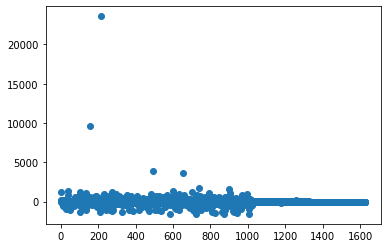

In [37]:
import matplotlib.pyplot as plt

plt.scatter([i for i in range(len(reg.coef_[0]))], reg.coef_)

In [ ]:
X_w2vec_test = w2vec_test.drop('Claps', axis=1)
y_w2vec_test = w2vec_test[['Claps']]

y_pred_w2vec = reg.predict(X_w2vec_test)

print(mean_squared_error(y_w2vec_test, y_pred_w2vec))
print(math.sqrt(mean_squared_error(y_w2vec_test, y_w2vec_elmo)))

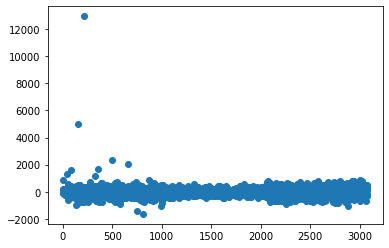

In [74]:
X = elmo_train.drop('Claps', axis=1)
y = elmo_train[['Claps']]
reg = LinearRegression().fit(X, y)
plt.scatter([i for i in range(len(reg.coef_[0]))], reg.coef_)

In [75]:
X = elmo_test.drop('Claps', axis=1)
y = elmo_test[['Claps']]

reg.score(X, y)

-3.6222646289668976

In [76]:
X_elmo_test = elmo_test.drop('Claps', axis=1)
y_elmo_test = elmo_test[['Claps']]

y_pred_elmo = reg.predict(X_elmo_test)

print(mean_squared_error(y_elmo_test, y_pred_elmo))
print(math.sqrt(mean_squared_error(y_elmo_test, y_pred_elmo)))

625001.4669081405
790.5703427957188


Судя по графикам, модель оферфитится на авторов (у нас в начале датафрейма авторы). Надо добавить регуляризацию, которая будет штрафовать за большие коэфициенты или убрать авторов совсем. На нашем семпле скорее всего продуктивнее всего будет просто убрать авторов, но на всей большой выборке лучше штрафовать за большие коэфициенты, что мы и сделаем. Заодно будем подбирать гиперпараметры с посощью grid search




In [45]:
m = max(reg.coef_[0])
[i for i, j in enumerate(reg.coef_[0]) if j == m]

[215]

In [46]:
w2vec_test.columns[215]

'author_Chris Darkes'

In [49]:
X_elmo_train = elmo_train.drop('Claps', axis=1)
y_elmo_train = elmo_train[['Claps']]
X_elmo_test = elmo_test.drop('Claps', axis=1)
y_elmo_test = elmo_test[['Claps']]

X_w2vec_train = w2vec_train.drop('Claps', axis=1)
y_w2vec_train = w2vec_train[['Claps']]
X_w2vec_test = w2vec_test.drop('Claps', axis=1)
y_w2vec_test = w2vec_test[['Claps']]

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

parameters = {'alpha':[5, 10, 15, 20, 1000, 1500, 2000]}

model = Ridge()
Ridge_reg_elmo = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=10, refit=False)
Ridge_reg_w2vec = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=10, refit=False)

Ridge_reg_elmo.fit(X_elmo_train,y_elmo_train)
Ridge_reg_w2vec.fit(X_w2vec_train,y_w2vec_train)


#best_model_elmo = Ridge_reg_elmo.best_estimator_
#best_model_w2vec = Ridge_reg_w2vec.best_estimator_

#best_model_elmo.fit(X_elmo_train,y_elmo_train)
#best_model_w2vec.fit(X_w2vec_train,y_w2vec_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [5, 10, 15, 20, 1000, 1500, 2000]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [114]:
pd.DataFrame(Ridge_reg_elmo.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.391000,0.009103,0.009168,0.000214,5,{'alpha': 5},-127231.531294,-1.789269e+06,-285225.199622,-261177.514907,-383584.752338,-154787.739499,-1.940698e+06,-223788.149020,-275449.166500,-406800.842288,-584801.229384,6.462322e+05,1
1,0.390701,0.011128,0.010095,0.001579,10,{'alpha': 10},-101699.993841,-2.310844e+06,-241054.739367,-252410.256310,-439167.128193,-122714.259417,-2.416025e+06,-196667.259151,-271509.226620,-462000.290983,-681409.214057,8.485234e+05,2
2,0.397296,0.012375,0.009386,0.000565,15,{'alpha': 15},-86192.182043,-2.594402e+06,-209134.888689,-244286.339875,-470834.385786,-103930.523473,-2.677141e+06,-174508.929874,-264009.391468,-493125.903438,-731756.494330,9.607280e+05,3
3,0.389345,0.006523,0.009380,0.000319,20,{'alpha': 20},-75601.510970,-2.778244e+06,-185256.400095,-238071.548381,-492024.510603,-91671.844574,-2.847492e+06,-157283.359064,-257226.368398,-513917.490185,-763678.965741,1.034264e+06,4
4,0.392712,0.009859,0.010292,0.001987,1000,{'alpha': 1000},-16958.581303,-3.863587e+06,-24841.814531,-194464.112295,-652462.128271,-20898.509632,-3.868591e+06,-26973.633491,-195286.310608,-656947.610470,-952101.117808,1.475251e+06,5
5,0.392746,0.007355,0.010012,0.002212,1500,{'alpha': 1500},-16772.180430,-3.887229e+06,-22785.629742,-194301.579725,-658784.928491,-19544.140721,-3.890968e+06,-24284.514151,-194801.909309,-661961.739868,-957143.346981,1.484541e+06,6
6,0.383690,0.010364,0.009183,0.000269,2000,{'alpha': 2000},-16726.527147,-3.900226e+06,-21666.326459,-194307.680550,-662466.356079,-18844.622122,-3.903235e+06,-22792.417601,-194649.531408,-664920.547948,-959983.486584,1.489616e+06,7


In [117]:
pd.DataFrame(Ridge_reg_w2vec.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.261022,0.011095,0.006527,0.000534,5,{'alpha': 5},-485983.040550,-85670.961964,-2.548989e+06,-129576.905710,-78008.684068,-485996.813484,-85671.367585,-2.548980e+06,-129576.502460,-78002.389625,-665645.601745,9.537613e+05,1
1,0.253040,0.006182,0.006219,0.000281,10,{'alpha': 10},-579607.108147,-95094.025510,-3.057242e+06,-152848.035069,-90111.741580,-579615.916932,-95093.915652,-3.057238e+06,-152847.337472,-90107.563651,-794980.583297,1.145707e+06,2
2,0.260066,0.007042,0.006318,0.000183,15,{'alpha': 15},-616659.009887,-96579.194579,-3.266102e+06,-161093.296009,-93041.769232,-616665.439660,-96578.965426,-3.266100e+06,-161092.565850,-93038.602273,-846695.063963,1.225329e+06,3
3,0.256604,0.007572,0.006818,0.000658,20,{'alpha': 20},-636259.882342,-96101.692184,-3.381794e+06,-164901.613514,-93516.860735,-636264.938458,-96101.426822,-3.381792e+06,-164900.911027,-93514.290318,-874514.740378,1.269854e+06,4
4,0.259378,0.010889,0.006991,0.001145,1000,{'alpha': 1000},-702591.064108,-79530.819986,-3.869583e+06,-171836.971799,-78861.180673,-702591.170900,-79530.807290,-3.869583e+06,-171836.928145,-78861.100231,-980480.654210,1.463056e+06,5
5,0.265185,0.005526,0.006789,0.000456,1500,{'alpha': 1500},-703971.214858,-79924.437808,-3.878198e+06,-172494.070794,-78935.307518,-703971.285078,-79924.429124,-3.878198e+06,-172494.040926,-78935.253505,-982704.652412,1.466276e+06,6
6,0.268178,0.011581,0.006819,0.000491,2000,{'alpha': 2000},-704798.896160,-80245.372656,-3.882873e+06,-172938.788627,-79058.786298,-704798.948369,-80245.366012,-3.882873e+06,-172938.765893,-79058.745644,-983983.011580,1.467987e+06,7


In [118]:
from sklearn.metrics import mean_squared_error
import math

clf = Ridge(alpha=1500)
clf.fit(X_elmo_train, y_elmo_train)
print(clf.score(X_elmo_train, y_elmo_train))

y_pred_elmo = clf.predict(X_elmo_test)

print(mean_squared_error(y_elmo_test, y_pred_elmo))
print(math.sqrt(mean_squared_error(y_elmo_test, y_pred_elmo)))

0.0326745931242014
131596.71689641898
362.76261783212857


In [119]:
from sklearn.metrics import mean_squared_error
import math

clf = Ridge(alpha=1000)
clf.fit(X_w2vec_train, y_w2vec_train)
print(clf.score(X_w2vec_train, y_w2vec_train))

y_pred_w2vec = clf.predict(X_w2vec_test)

print(mean_squared_error(y_w2vec_test, y_pred_w2vec))
print(math.sqrt(mean_squared_error(y_w2vec_test, y_pred_w2vec)))

0.014642079505400307
73127.05618986495
270.4201475294785


### Блок 3: Paraphrase Detection (до 8 баллов)


* [Статья по русскоязычному корпусу парафразов](https://www.aclweb.org/anthology/2020.ngt-1.6/)
* [Еще статья](http://www.dialog-21.ru/media/3928/loukachevitchnvetal.pdf)
* [Сайт корпуса](http://paraphraser.ru/)

Отформатированные данные можно скачать [здесь](https://yadi.sk/d/OIgbnRA6OVJ4VQ)


1.   Эксплоративный анализ данных (1 балл)
2.   Поиск гиперпараметров, минимизация переобучения (2 балла)
3.   Аугментация данных (1 балл)
4.   Сравнение качества моделей, выбор наилучшей (1 балл)
5.   Конструирование текстовых признаков (2 балла)
6.   Анализ ошибок (1 балл)



In [120]:
para = pd.read_csv("paraphrases.tsv", sep="\t")
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1


In [121]:
para.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_1  8540 non-null   object
 1   text_2  8540 non-null   object
 2   class   8540 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 200.3+ KB


In [123]:
para['class'].value_counts()

-1    5164
 1    3376
Name: class, dtype: int64

In [162]:
para = para.sample(100)

In [163]:
para['text_1_aug'] = para['text_1'].apply(augment_word2vec_pos)
para['text_2_aug'] = para['text_2'].apply(augment_word2vec_pos)

In [165]:
para.head()

,text_1,text_2,class,text_1_aug,text_2_aug
3720,"Молодые футболисты ЦСКА обыграли ""Баварию"" в Л...",«Бавария» разгромила ЦСКА в матче Лиги чемпионов.,-1,Молодые хоккеисты ЦСКА обыграли Баварию в Лиге,« Бавария » разгромила ЦСКА в матче
6662,В США во время учений погибли два сотрудника ФБР.,Два агента ФБР погибли на учениях.,1,В США во время учений погибли два руководителя...,Два шпиона ФБР погибли на учениях
3459,На центральную таможню России пришли с обыском.,Что Россия и Черногория значат друг для друга.,-1,На центральную таможню России пришли с арестом,Что Россия и болгария значат друг для друга
7206,Финансовая G20 решила отказаться от валютных в...,G20 отказалась вести валютные войны.,1,Финансовая G 20 решила отказаться,G 20 отказалась
2904,Скончался основатель рок-группы Soft Machine.,Скончался основатель британской рок-группы Sof...,1,Скончался основоположник рок-группы,Скончался основоположник британской рок-группы


In [ ]:
list_para = [para[i:i+100] for i in range(0,medium.shape[0],100)]
elmo_text_1 = [elmo_vectors(x['text_1']) for x in list_para]
elmo_text_1_new = np.concatenate(elmo_text_1, axis = 0)
list_para

In [ ]:
para['text_1_elmo'].apply(elmo_text_1_new)

In [ ]:
elmo_text_2 = [elmo_vectors(x['text_2']) for x in list_para]
elmo_text_2_new = np.concatenate(elmo_text_1, axis = 0)

In [ ]:
para['text_2_elmo'].apply(elmo_text_2_new)